In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from game import Game
from direction import Direction

pygame 2.3.0 (SDL 2.24.2, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def play_random_game():
    # Initialize the random game
    random_game = Game()

    # Initialize the board
    init_board = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
    board = random_game.add_tile(init_board)
    board = random_game.add_tile(board)

    # Step through the game loop
    total_score = 0
    game_over = False
    while not game_over:
        board, reward, game_over = random_game.step(board, random.choice(list(Direction)))
        total_score += reward.action_score

    # print(f'Score: {total_score}')
    # print(f'Max: {np.amax(board)}')
    # print(board)

    return board, total_score

**Baseline**

In [26]:
baseline_episodes = 10000
baseline_scores = []
baseline_best_tiles = []

for episode in tqdm(range(baseline_episodes), total=baseline_episodes):
    board, score = play_random_game()
    baseline_scores.append(score)
    baseline_best_tiles.append(np.amax(board))


100%|██████████| 10000/10000 [04:15<00:00, 39.14it/s]


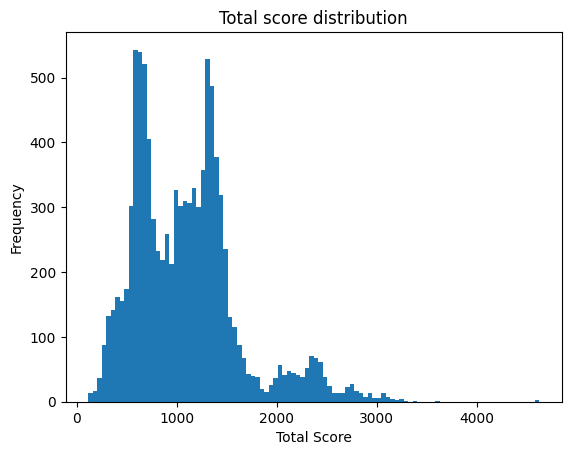

In [27]:
# Score distribution
plt.hist(baseline_scores, bins = 100)
plt.title("Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

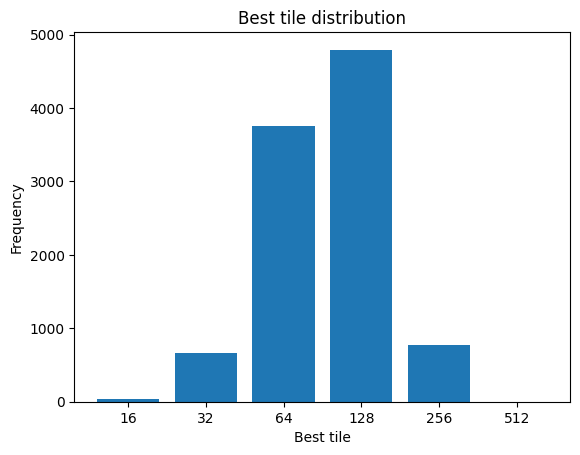

In [28]:
import math

# Best tile distribution
max_power = int(math.log(max(baseline_best_tiles), 2)) + 1
min_power = int(math.log(min(baseline_best_tiles), 2))
unique, counts = np.unique(baseline_best_tiles, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# TODO: refactor plots into functions

**Training**

In [3]:
from memory import ReplayMemory, Experience
from qnet import QNet
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [36]:
# TODO: refactor constants
MEM_CAPACITY = 100000
NUM_STATES = 16
NUM_ACTIONS = 4
LEARNING_RATE = 5e-5
EPISODES = 1000
EPSILON_START = 0.9
EPSILON_END = 0.01
EPSILON_DECAY = 0.9999
UPDATE_TARGET = 200
BATCH_SIZE = 32
LEARN_ITERATIONS = 100
GAMMA = 0.99

# Initialize replay memory
replay_memory = ReplayMemory(MEM_CAPACITY)

# Initialize action-value function and target action-value function
qnet = QNet(NUM_STATES, NUM_ACTIONS).to(device)
qnet_target = QNet(NUM_STATES, NUM_ACTIONS).to(device)
qnet.train()
qnet_target.eval()

# Initialize optimization functions
criterion = nn.MSELoss()
optimizer = optim.Adam(qnet.parameters(), lr=LEARNING_RATE)

# Iterate through the episodes
iterations = 0
epsilon = EPSILON_START
trained_scores = []
trained_best_tiles = []
for episode in tqdm(range(EPISODES), total=EPISODES):
    # Initialize game for episode
    episode_game = Game()

    # Initialize the board
    # TODO: refactor board initialization in game class
    init_board = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
    board = episode_game.add_tile(init_board)
    board = episode_game.add_tile(board)

    # Step through the episode
    episode_score = 0
    episode_done = False
    while not episode_done:

        # TODO: add functionality to save an episode or every C episodes

        # With probability epsilon select a random action, else choose from policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(list(Direction))
        else:
            qnet.eval()
            with torch.no_grad():
                action = torch.argmax(qnet(board))
                action = Direction(action.item())
            qnet.train()
        
        # Update epsilon
        epsilon = epsilon * EPSILON_DECAY
        epsilon = max(epsilon, EPSILON_END)

        # Execute action and observe reward
        result = episode_game.step(board, action)
        reward = result[1].get_total_reward()
        episode_score += result[1].action_score
        
        replay_memory.memory.append(Experience(board, action, reward, result[0]))

        board = result[0]
        episode_done = result[2]

        if episode_done:
            # Optimize model if 
            if len(replay_memory) > BATCH_SIZE:
                for i in range(LEARN_ITERATIONS):
                    experiences = replay_memory.sample(BATCH_SIZE)
                    states = []
                    actions = []
                    rewards = []
                    next_states = []
                    for experience in experiences:
                        states.append(experience.state)
                        actions.append(experience.action)
                        rewards.append(experience.reward)
                        next_states.append(experience.next_state)
                                        
                    states = np.array(states)
                    actions = torch.tensor([act.value for act in actions]).unsqueeze(1)
                    rewards = torch.tensor(rewards)
                    next_states = np.array(next_states)
                    
                    # Get the Q values for each action
                    q_vals = qnet(states)

                    # Gather the Q values for the action that was taken
                    estimated_actions = torch.gather(q_vals, 1, actions)

                    expected_actions = qnet_target(next_states).max(1)[0].detach().float()
                    expected_actions = (expected_actions * GAMMA) + rewards
                    expected_actions = expected_actions.float()

                    loss = criterion(estimated_actions, expected_actions.unsqueeze(1))

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

    trained_scores.append(episode_score)
    trained_best_tiles.append(np.amax(board))


    # Every C steps reset target model
    if episode % UPDATE_TARGET == 0:
        qnet_target.load_state_dict(qnet.state_dict())
        qnet.train()

  1%|▏         | 13/1000 [04:14<5:22:25, 19.60s/it]


KeyboardInterrupt: 

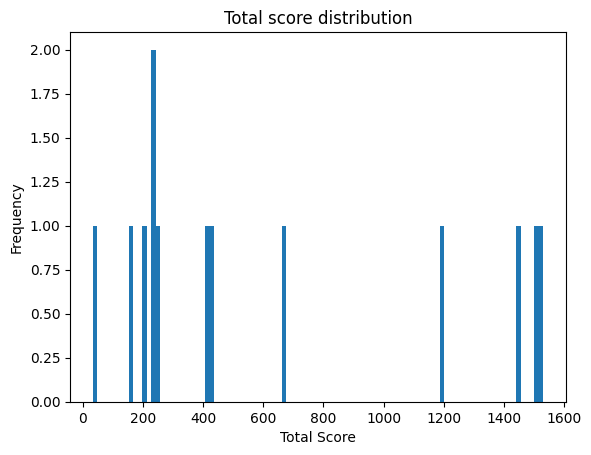

In [37]:
# Score distribution
plt.hist(trained_scores, bins = 100)
plt.title("Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

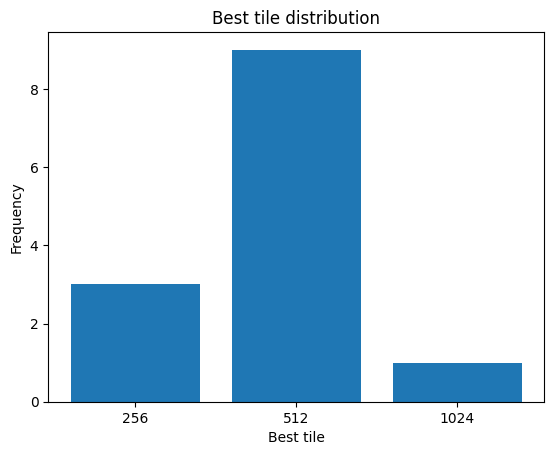

In [38]:
import math

# Best tile distribution
max_power = int(math.log(max(trained_best_tiles), 2)) + 1
min_power = int(math.log(min(trained_best_tiles), 2))
unique, counts = np.unique(trained_best_tiles, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()